In [45]:
import PIL
import mss
import pyautogui 
import time  
import numpy  as np  
import matplotlib
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import load_model
import os
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

pyautogui.PAUSE = 0.01

SHOULD_LOG = True

/Users/in-emmanuel.philip/PycharmProjects/trial/venv/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/in-emmanuel.philip/PycharmProjects/trial/venv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/in-emmanuel.philip/PycharmProjects/trial/venv/lib/python2.7/site-packages/traitlet

In [16]:
restart_coords = (420, 370)
    
def restart():
    #pyautogui.click(restart_coords)
    pyautogui.keyDown('space')
    pyautogui.keyUp('space')    


def jump(should_jump):
    if should_jump:
        pyautogui.keyDown('space')
        pyautogui.keyUp('space')
        

def check_val_and_jump(val):
    if val>0.5: 
        jump(True)
        return 1
    else:
        jump(False)
        return 0

In [1]:
def display_image(image, title):
    plt.figure().suptitle(title, fontsize=20)
    plt.imshow(image)
    plt.show()
    
def capture_image():
    image = mss.mss().grab({"top":350, "left":50, "width":700, "height":200})
    return PIL.Image.frombytes("RGB", image.size, image.bgra, "raw", "BGRX")

def convert_to_greyscale_image(color_image):
    THRESHOLD_VALUE = 125
    image = color_image.convert("L")
    orig_image = np.asarray(image)
    image = image.resize((300, 300), PIL.Image.ANTIALIAS)
    img_data = np.asarray(image)
    greyscale_image = (img_data > THRESHOLD_VALUE) * 1.0
    return greyscale_image, orig_image
    

def get_state_image(index, show):
    
    image = capture_image()
    
    greyscale_image, orig_image = convert_to_greyscale_image(image)
    
    if show:
        display_image(greyscale_image, index)
    return np.asarray(greyscale_image), orig_image
    
a,b = get_state_image(-1, True)



IndentationError: expected an indented block (<ipython-input-1-66b8f2abcb89>, line 14)

In [105]:
def build_model():
    cnn_model = Sequential()
    
    cnn_model.add(Conv2D(9, (21, 21), strides=(7, 7), padding='valid',input_shape=(300, 300, 1), activation='relu',
                     kernel_initializer='random_uniform'))  #20*40*4
    cnn_model.add(Conv2D(13, (11, 11), strides=(3, 3), padding='same', activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(Conv2D(25, (5, 5), strides=(1, 1), padding='same', activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    cnn_model.add(Conv2D(39, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(Dense(32, activation='relu', kernel_initializer='random_uniform'))
    cnn_model.add(Dense(2, activation='relu', kernel_initializer='random_uniform'))
    cnn_model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    if not os.path.isfile('my_dino.h5'):     
        cnn_model.save('my_dino.h5')


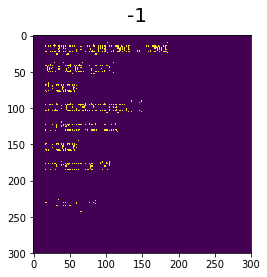

('Prediction output', 0.50006425)
('Prediction time', 0.05360698699951172)


In [99]:
model = build_model()

input_area, origImage = get_state_image(-1, True)
input_area_conv = input_area[np.newaxis, ..., np.newaxis]
model = load_model('my_dino.h5')
t0 = time.time()
output = model.predict(input_area_conv)[0][0]
print('Prediction output', output)
t1 = time.time()
print('Prediction time', t1-t0)

# model.save('my_dino.h5')
    



In [93]:
def normalize_output(output_list):
    return [ 1 if val > 0.5 else 0 for val in output_list ]
    
def flip_output(val):
    if val == 1:
        return 0
    else:
        return 1
    
    

In [108]:

def train_data(input_data, output_data):
    print('Training output:', np.asarray(output_data).shape)
    print('Training output:', np.asarray(output_data).shape)
    del input_data[-10:]
    del output_data[-10:]
        
    for i in range(len(output_data)):
        if output_data[i][0]>0.5:
            output_data[i][0] = 1
        else:
            output_data[i][0] = 0
    model.train_on_batch(np.asarray(input_data), np.asarray(output_data))
    model.save_weights('my_dino.h5', overwrite=True)
        

In [ ]:
itr = 0
model = load_model('my_dino.h5')
time.sleep(5)

prev_area = None
restart()
train_x = []
train_y = []
num = 0
while True:
    time1 = time.time()
    input_area, origImage = get_state_image(num, False)
    input_area_conv = input_area[np.newaxis, ..., np.newaxis]
    t2 = time.time()
    print('dtctn tm:', t2 - time1)
    if prev_area is not None and num>5 and np.array_equal(origImage, prev_area):
        itr = itr + 1
        if itr%5 == 0:
            clear_output()
        print(np.asarray(train_x).shape)
        print(np.asarray(train_x).shape)
        if num>45:
            train_data(train_x, train_y)
        
            # print('length of training set', len(train_x))
            # print('train_x_shape before training', np.asarray(train_x).shape)
            # print('train_y_shape before t raining', np.asarray(train_y).shape)
        t3 = time.time()
        prev_area = None
        # print('Training time', t3-t2)
        num = 0
        restart()
        if itr == 100:
            break
    else:
        t3 = time.time()
        output = model.predict(input_area_conv)[0][0]
        print('Prdctn output', num, ': ', output)
        t4 = time.time()
        print('Prdctn Time:' , t4 - time1)
        t = 0.15-(time.time()-t3)
        # print(t)
        time.sleep(t)
        output = np.int32(check_val_and_jump(output))
            
        num = num + 1
        train_x.append(input_area[..., np.newaxis])
        # print('train_x_shape', np.asarray(train_x).shape)
        # print('Prediction Output', output)
        train_y.append(output[..., np.newaxis])
        # print('train_y_shape', np.asarray(train_y).shape)
        
    prev_area = origImage
    time2 = time.time()
    print('Loop time:', time2 - time1)



(1799, 300, 300, 1)
(1799, 300, 300, 1)
('Loop time:', 2.5181868076324463)
('dtctn tm:', 0.02635788917541504)
('Prdctn output', 0, ': ', 1.0)
('Prdctn Time:', 0.032173871994018555)
('Loop time:', 0.22463297843933105)
('dtctn tm:', 0.024200916290283203)
('Prdctn output', 1, ': ', 1.0)
('Prdctn Time:', 0.028862953186035156)
('Loop time:', 0.23661494255065918)
('dtctn tm:', 0.0325930118560791)
('Prdctn output', 2, ': ', 1.0)
('Prdctn Time:', 0.037780046463012695)
('Loop time:', 0.2520918846130371)
('dtctn tm:', 0.026495933532714844)
('Prdctn output', 3, ': ', 1.0)
('Prdctn Time:', 0.03084588050842285)
('Loop time:', 0.22457504272460938)
('dtctn tm:', 0.02805304527282715)
('Prdctn output', 4, ': ', 1.0)
('Prdctn Time:', 0.033735036849975586)
('Loop time:', 0.22607898712158203)
('dtctn tm:', 0.032614946365356445)
('Prdctn output', 5, ': ', 1.0)
('Prdctn Time:', 0.036711931228637695)
('Loop time:', 0.23015999794006348)
('dtctn tm:', 0.0455470085144043)
(1805, 300, 300, 1)
(1805, 300, 300, 1)